<a href="https://colab.research.google.com/github/LaurentTits/AI_execices/blob/main/DB3_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Thu Nov 17 10:00:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [2]:

from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files, drive
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

drive.mount('/content/gdrive')

Tensorflow version: 2.9.2
Keras version: 2.9.0
Mounted at /content/gdrive


#**3. Téléchargement des données d'entrainement "DB3"**

In [15]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [16]:
!rm -rf sample_data
! wget --no-check-certificate https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
! tar xf FIRE_DATABASE_3.tar -C 'bases' --one-top-level
! rm FIRE_DATABASE_3.tar

--2022-11-17 10:25:29--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471111680 (449M) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_3.tar’

FIRE_DATABASE_3.tar 100%[===================>] 449.29M  13.3MB/s    in 40s     

2022-11-17 10:26:11 (11.4 MB/s) - ‘FIRE_DATABASE_3.tar’ saved [471111680/471111680]



#**3. Téléchargement des données de test "Test Dataset"**

In [17]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
! tar xf test.tar -C 'bases' --one-top-level
! rm test.tar

--2022-11-17 10:26:25--  http://195.154.53.219/downloads/test.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58196480 (56M) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]  55.50M  13.8MB/s    in 5.0s    

2022-11-17 10:26:30 (11.2 MB/s) - ‘test.tar’ saved [58196480/58196480]



#**4. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [36]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=200 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}  
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_3","DB2","DB3","own_DB"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "/content/gdrive/MyDrive/classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **5. Compter le nombre de classes**

In [19]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **6. Création du jeu de données d'entraînement**

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


#**7. Créer le jeu de validation**

In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="validation",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


In [26]:
classes = ['fire','no_fire','start_fire']

for class_name in classes:
  # folder path
  dir_path = train_dataset + '/' +class_name
  count = 0
  # Iterate directory
  for path in os.listdir(dir_path):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1
  print('File count '+class_name+' :', count)


File count fire : 500
File count no_fire : 500
File count start_fire : 500


# **8. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [32]:
base_model = Xception(include_top=False, weights='imagenet', input_shape = (input_dim, input_dim, 3))
#create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

#freeze the model except three last layers
for layer in model.layers[:-3]:
  layer.trainable = False

In [ ]:
print(model.summary())

# **9. Geler puis dégeler les poids des premières couches**

In [ ]:
# base_model.trainable = False
# print(model.summary())
# base_model.trainable = True

# **10. Compiler le modèle avec la descente de gradient stochastique DSG**


In [33]:
# recompiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# **11. Entraîner le modèle**

In [34]:
#for layer in base_model.layers:
#  layer.trainable = False
#base_model.trainable = False

stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                        verbose=1, mode='auto')
#ckpt_save = os.path.join(".",'model_fine_ep{epoch}_valloss{val_loss:.3f}.h5')
ckpt_save = os.path.join("/content/gdrive/MyDrive",'xception_db3_ep{epoch}_valloss{val_loss:.3f}.h5')

checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

callback_list = [checkpoint, stopper]

history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
                    epochs=epochs, callbacks=callback_list)




Epoch 1/200
38/38 [==============================] - ETA: 0s - loss: 80.6917 - accuracy: 0.6108
Epoch 1: val_loss improved from inf to 1.12776, saving model to /content/gdrive/MyDrive/xception_db3_ep1_valloss1.128.h5
38/38 [==============================] - 23s 483ms/step - loss: 80.6917 - accuracy: 0.6108 - val_loss: 1.1278 - val_accuracy: 0.4833
Epoch 2/200
38/38 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.6833
Epoch 2: val_loss improved from 1.12776 to 0.61996, saving model to /content/gdrive/MyDrive/xception_db3_ep2_valloss0.620.h5
38/38 [==============================] - 21s 512ms/step - loss: 0.8864 - accuracy: 0.6833 - val_loss: 0.6200 - val_accuracy: 0.7733
Epoch 3/200
38/38 [==============================] - ETA: 0s - loss: 0.8579 - accuracy: 0.7208
Epoch 3: val_loss did not improve from 0.61996
38/38 [==============================] - 22s 505ms/step - loss: 0.8579 - accuracy: 0.7208 - val_loss: 0.6978 - val_accuracy: 0.7267
Epoch 4/200
38/38 [=====

#**13. Choix de la répartition train-validation**

In [37]:
base_model = Xception(include_top=False, weights='imagenet', input_shape = (input_dim, input_dim, 3))
#create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

#freeze the model except three last layers
for layer in model.layers[:-3]:
  layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

histories = []
val_splits = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9]
count = 0

for val_split in val_splits:
    print('valsplit : '+valsplit)
    stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                            verbose=1, mode='auto')
    #ckpt_save = os.path.join(".",'model_fine_ep{epoch}_valloss{val_loss:.3f}.h5')
    ckpt_save = os.path.join("/content/gdrive/MyDrive",'xception_db3_split-{val_split}_ep{epoch}_valloss{val_loss:.3f}.h5')

    checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

    callback_list = [checkpoint, stopper]
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dataset,               # chemin vers le jeu de données
      validation_split=val_split,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
      subset="training",           # Sélection du jeu de données d'entraînement
      seed=42,                     # Initialisation du générateur aléatoire (permutations)
      image_size=(input_dim, input_dim),   # Taille des images d'entrée
      batch_size=batch_size,   # Taille du mini-batch
      label_mode='categorical'    # Conversion au format One-Hot
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dataset,               # chemin vers le jeu de données
      validation_split=val_split,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
      subset="validation",           # Sélection du jeu de données d'entraînement
      seed=42,                     # Initialisation du générateur aléatoire (permutations)
      image_size=(input_dim, input_dim),   # Taille des images d'entrée
      batch_size=batch_size,   # Taille du mini-batch
      label_mode='categorical'    # Conversion au format One-Hot
    )
    history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
                    epochs=epochs, callbacks=callback_list)
    histories.append(history)
    count += 1

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')

    plt.show()




NameError: ignored

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
# checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

#model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)

#history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
#                    epochs=epochs, callbacks=[model_checkpoint_callback])

model.save('models/db1model')


In [ ]:
saved_model = keras.models.load_model('models/firstmodel')


In [ ]:
db3_model = keras.models.load_model('/content/gdrive/MyDrive/model_db3_ep4_valloss0.111.h5')

#**14. Afficher des courbes d'entrainement/validation**

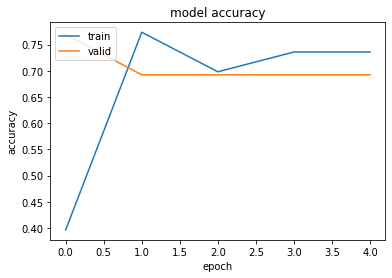

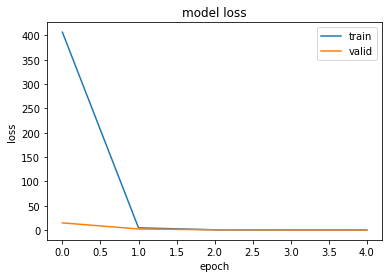

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.show()

# **15. Créer le jeu de données de test**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	test_dataset,               # chemin vers le jeu de données
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
  batch_size=batch_size,   # not useful for test_ds
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 210 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [ ]:
score = model.evaluate(test_ds)
print('score', score[0], score[1])

27/27 [==============================] - 3s 86ms/step - loss: 1.4878 - accuracy: 0.5429
score 1.4878332614898682 0.5428571701049805


In [ ]:
score = db3_model.evaluate(test_ds)
print('score', score[0], score[1])

#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

1/1 [==============================] - 1s 645ms/step
Class Name : fire --- Class Probability: 22.89%
Class Name : no_fire --- Class Probability: 36.09%
Class Name : start_fire --- Class Probability: 41.01%


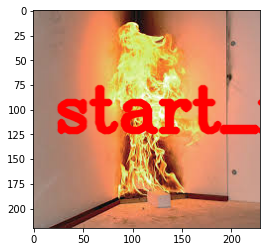

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 20ms/step
Class Name : fire --- Class Probability: 0.81%
Class Name : no_fire --- Class Probability: 96.00%
Class Name : start_fire --- Class Probability: 3.19%


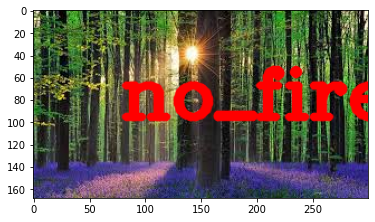

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 20ms/step
Class Name : fire --- Class Probability: 31.04%
Class Name : no_fire --- Class Probability: 15.16%
Class Name : start_fire --- Class Probability: 53.80%


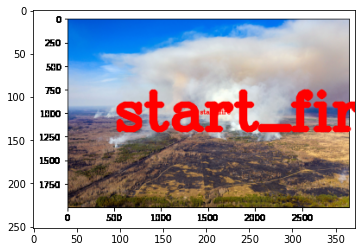

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "start_fire.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

Saving 0.png to 0.png


1/1 [==============================] - 0s 20ms/step
Class Name : fire --- Class Probability: 34.08%
Class Name : no_fire --- Class Probability: 33.00%
Class Name : start_fire --- Class Probability: 32.91%


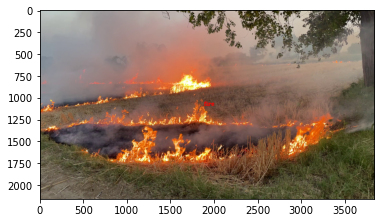

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "0.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files, drive
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
classes_path = "/content/gdrive/MyDrive/classes.txt"
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

In [ ]:
first_model = keras.models.load_model('/content/gdrive/MyDrive/model_fine_ep5_valloss0.222.h5')

In [ ]:
files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

1/1 [==============================] - 0s 26ms/step
Class Name : fire --- Class Probability: 34.12%
Class Name : no_fire --- Class Probability: 33.04%
Class Name : start_fire --- Class Probability: 32.83%


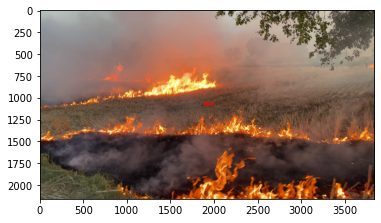

In [ ]:
%matplotlib inline

input_dim=299
image_path =  "4.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()